# ISLP - Chapter 7 - Exercise 9
### Author: pzuehlke

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from IPython.display import display, Math  # for rendering the polynomials using LaTeX
from statsmodels.api import OLS
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator
from ISLP.models import (summarize, bs, ModelSpec as MS)
from ISLP.models import sklearn_sm

In [2]:
boston = pd.read_csv("Boston.csv")
boston.dropna(inplace=True)
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   crim        506 non-null    float64
 2   zn          506 non-null    float64
 3   indus       506 non-null    float64
 4   chas        506 non-null    int64  
 5   nox         506 non-null    float64
 6   rm          506 non-null    float64
 7   age         506 non-null    float64
 8   dis         506 non-null    float64
 9   rad         506 non-null    int64  
 10  tax         506 non-null    int64  
 11  ptratio     506 non-null    float64
 12  lstat       506 non-null    float64
 13  medv        506 non-null    float64
dtypes: float64(10), int64(4)
memory usage: 55.5 KB


In [3]:
X = boston["dis"].values.reshape(-1, 1)  # Reshape for sklearn
y = boston["nox"].values

__9 (a):__ We will use scikit-learn instead of ISLP because the former is much
more standard for this type of task. For this item, we only need to transform
the original $ X = \text{dis} $ into polynomial features and then use least
squares to fit a cubic polynomial:

In [4]:
poly3_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=3)),
    ("linear", LinearRegression())
])
poly3_pipeline.fit(X, y)

# Extract coefficients for reporting:
poly_model = poly3_pipeline.named_steps["linear"]
coefs = poly_model.coef_
a = coefs[3]
b = coefs[2]
c = coefs[1]
d = coefs[0]

print("Cubic polynomial regression results:")
display(Math(f"{a:.3f}x^3 + {b:.3f}x^2 + {c:.3f}x + {d:.3f}"))
# Calculate R-squared and RSS:
y_pred_poly3 = poly3_pipeline.predict(X)
r_squared = r2_score(y, y_pred_poly3)
rss = np.sum((y - y_pred_poly3)** 2)
display(Math(f"R^2: {r_squared:.3f}"))
display(Math(f"RSS: {rss:.3f}"))

Cubic polynomial regression results:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now we plot the fitted polynomial together with the data:

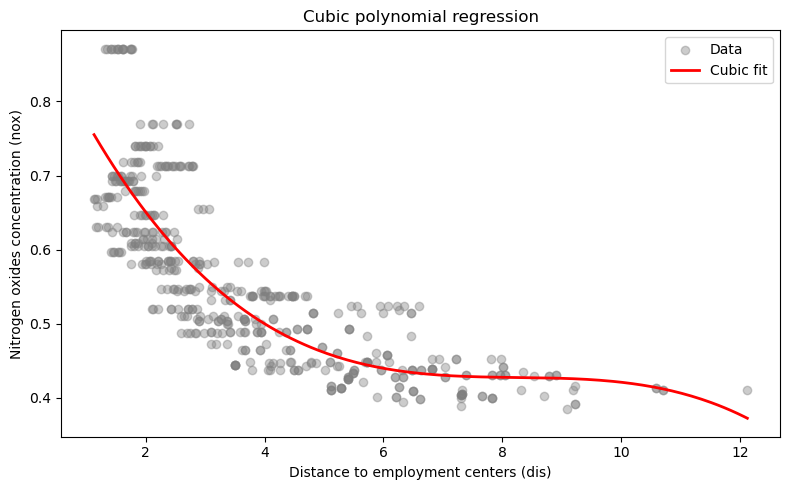

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X, y, alpha=0.4, color="gray", label="Data")

X_plot = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_plot_poly3 = poly3_pipeline.predict(X_plot)

ax.plot(X_plot, y_plot_poly3, color="red", linewidth=2, label="Cubic fit")
ax.set_xlabel("Distance to employment centers (dis)")
ax.set_ylabel("Nitrogen oxides concentration (nox)")
ax.set_title("Cubic polynomial regression")
ax.legend()
plt.tight_layout()
plt.show()

__9 (b):__ The workflow is the same as for item (a), except we loop over
the degrees of the fitted polynomials:

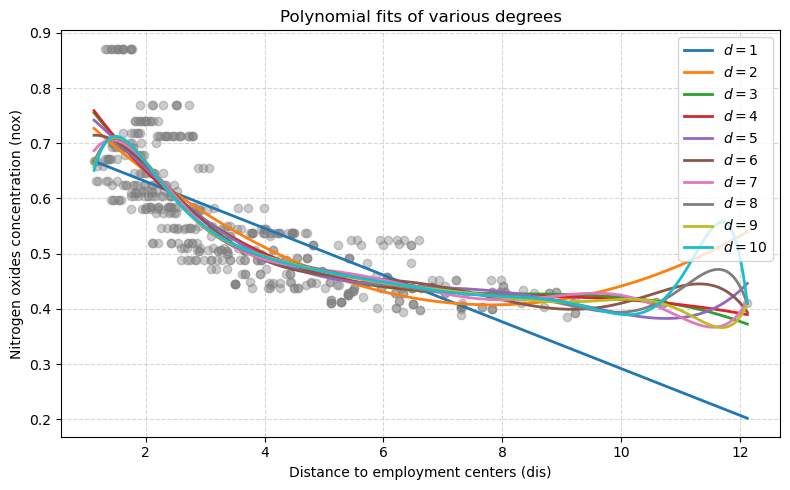

In [6]:
# Fit polynomials of degrees 1 to 10 using pipelines:
degrees = range(1, 11)
rss_values = []

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X, y, alpha=0.4, color="gray")
# Generate points on the x-axis for smooth curves:
X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)

for d in degrees:
    poly_pipeline = make_pipeline(
        PolynomialFeatures(degree=d),
        LinearRegression()
    )
    poly_pipeline.fit(X, y)
    # Predict and calculate RSS:
    y_pred = poly_pipeline.predict(X)
    rss = np.sum((y - y_pred)** 2)
    rss_values.append(rss)
    # Plot the polynomial fit:
    y_plot_poly = poly_pipeline.predict(X_plot)
    ax.plot(X_plot, y_plot_poly, linewidth=2, label=f"$ d = {d} $")

ax.set_xlabel("Distance to employment centers (dis)")
ax.set_ylabel("Nitrogen oxides concentration (nox)")
ax.set_title("Polynomial fits of various degrees")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

It seems that for degrees $ \ge 3 $, the fitted polynomials differ only near the
boundaries of the range of the $ \text{dis} $ values. Let's plot the $ \text{RSS} $
against the degree and report the former:

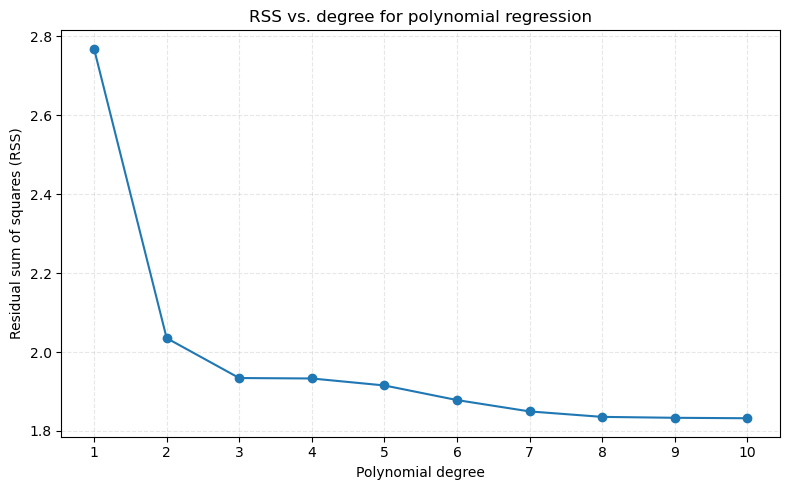

Degree  1, RSS = 2.7686
Degree  2, RSS = 2.0353
Degree  3, RSS = 1.9341
Degree  4, RSS = 1.9330
Degree  5, RSS = 1.9153
Degree  6, RSS = 1.8783
Degree  7, RSS = 1.8495
Degree  8, RSS = 1.8356
Degree  9, RSS = 1.8333
Degree 10, RSS = 1.8322


In [7]:
# Plot RSS vs. polynomial degree
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(degrees, rss_values, marker="o", linestyle="-")
ax.set_xlabel("Polynomial degree")
ax.set_ylabel("Residual sum of squares (RSS)")
ax.set_title("RSS vs. degree for polynomial regression")
ax.grid(True, linestyle="--", alpha=0.3)
ax.set_xticks(degrees)
plt.tight_layout()
plt.show()

# Report RSS values
for d, rss in zip(degrees, rss_values):
    print(f"Degree {d:2d}, RSS = {rss:.4f}")

Note that the training $ \text{RSS} $ decreases as $ d $ increases, as it
should, since a model of a particular degree includes as special cases all
models of lower degree.

__9 (c):__ We will use $ 5 $-fold cross-validation with pipelines to find the optimal polynomial degree.

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
cv_rmse_values = []  # list to store root mean squared errors
for d in degrees:
    poly_pipeline = make_pipeline(
        PolynomialFeatures(degree=d),
        LinearRegression()
    )
    cv_scores = -cross_val_score(
        poly_pipeline, X, y, cv=cv, scoring="neg_mean_squared_error"
    )
    cv_rmse_values.append(np.sqrt(cv_scores.mean()))

We now plot the CV RMSE against the degree $ d = 1, 2, \cdots, 10 $ to conclude
that the optimal degree based on cross-validation seems to be $ d = 3 $. This
again illustrates the fact that the most flexible model is not always the best
one, due to the bias/variante trade-off.

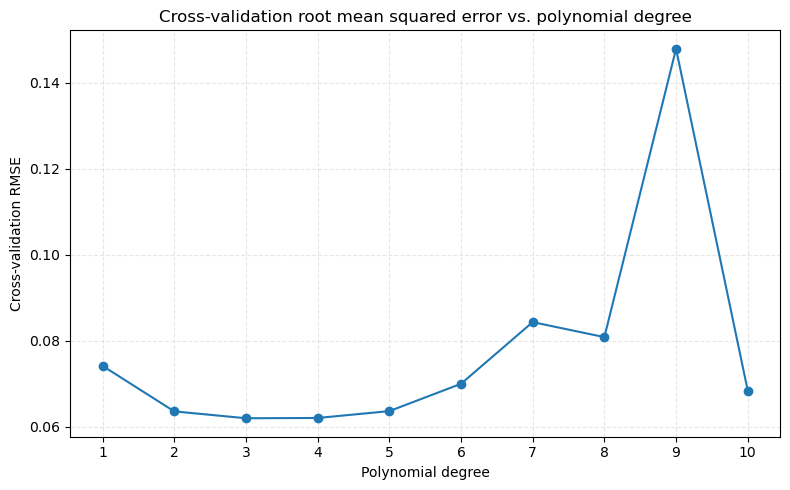

Optimal polynomial degree based on CV: 3


In [ ]:
# Plot CV RMSE vs polynomial degree:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(degrees, cv_rmse_values, marker="o", linestyle="-")
ax.set_xlabel("Polynomial degree")
ax.set_ylabel("Cross-validation RMSE")
ax.set_title("Cross-validation root mean squared error vs. polynomial degree")
ax.grid(True, linestyle="--", alpha=0.3)
ax.set_xticks(degrees)
plt.tight_layout()
plt.show()

optimal_degree = degrees[np.argmin(cv_rmse_values)]
print(f"Optimal polynomial degree based on CV: {optimal_degree}")

__9 (d):__  This time we will use the ISLP package since the splines in scikit-learn
are not exactly equivalent to those in the text.

In [ ]:
dis = boston["dis"]
nox = boston["nox"]

dis_grid = np.linspace(dis.min(), dis.max(), 500)
dis_df = pd.DataFrame({"dis": dis_grid})

In [11]:
# Fit regression spline with 4 degrees of freedom:
bs_dis = MS([bs("dis", df=4)]).fit(boston)
X = bs_dis.transform(boston)
M_bs = sm.OLS(nox, X).fit()
summarize(M_bs)

,coef,std err,t,P>|t|
intercept,0.7345,0.015,50.306,0.000
"bs(dis, df=4)[0]",-0.0581,0.022,-2.658,0.008
"bs(dis, df=4)[1]",-0.4636,0.024,-19.596,0.000
"bs(dis, df=4)[2]",-0.1998,0.043,-4.634,0.000
"bs(dis, df=4)[3]",-0.3888,0.046,-8.544,0.000


We will now plot the spline together with $ 95\% $ confidence intervals. For
cubic splines with four degrees of freedom, we expect one interior knot at the
median (see the discussion on p. $ 316 $):

Expected knot position (median): 3.2074


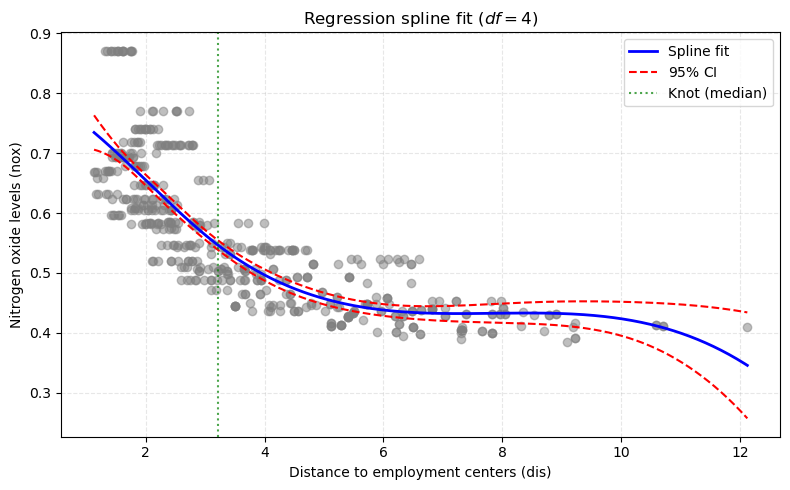

In [12]:
knot_position = np.median(dis)
print(f"Expected knot position (median): {knot_position:.4f}")

# Plot the spline fit:
Xnew = bs_dis.transform(dis_df)
preds = M_bs.get_prediction(Xnew)
bands = preds.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(dis, nox, facecolor="gray", alpha=0.5)
ax.plot(dis_grid, preds.predicted_mean, "b-", linewidth=2, label="Spline fit")
ax.plot(dis_grid, bands[:, 0], "r--", linewidth=1.5, label="$ 95\\% $ CI")
ax.plot(dis_grid, bands[:, 1], "r--", linewidth=1.5)
# Mark the expected knot position:
ax.axvline(x=knot_position, color="green", linestyle=":", alpha=0.7, 
           label="Knot (median)")
ax.set_title("Regression spline fit ($ df=4 $)")
ax.set_xlabel("Distance to employment centers (dis)")
ax.set_ylabel("Nitrogen oxide levels (nox)")
ax.legend()
ax.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

__9 (e):__ We will try splines of degrees ranging from $ 3 $ to $ 10 $.
We just need to repeat the same code as in item (d), but inside a for loop:

In [20]:
# Range of degrees of freedom to try:
df_range = range(3, 11)
RSS = {}
fits = {}

# Fit models and calculate RSS:
for df in df_range:
    bs_model = MS([bs("dis", df=df)]).fit(boston)
    X = bs_model.transform(boston)
    model = sm.OLS(nox, X).fit()

    yhat = model.predict(X)
    RSS[df] = np.sum((nox - yhat)**2)

    X_grid = bs_model.transform(dis_df)
    fits[df] = model.predict(X_grid)

rss_table = pd.DataFrame({
    "Degrees of freedom": list(RSS.keys()),
    "RSS": list(RSS.values()),
}).set_index("Degrees of freedom")

rss_table

,RSS
Degrees of freedom,
3,1.934107
4,1.922775
5,1.840173
6,1.833966
7,1.829884
8,1.816995
9,1.825653
10,1.792535


We see that the training RSS decreases as the degrees of freedom increase, with
the exception of the transition from $ 8 $ to $ 9 $ degrees of freedom.  This is
unexpected, since the class of cubic splines having $ 9 $ degrees of freedom
includes the class of splines having $ 8 $ degrees of freedom, at least if we
are free to choose the positions of the knots.  However, in our code the
position of the knots is chosen at uniform quantiles of the data
(see p. $ 316 $), so there is no contradiction.

We now plot RSS against the degrees of freedom and also the cubic splines themselves.

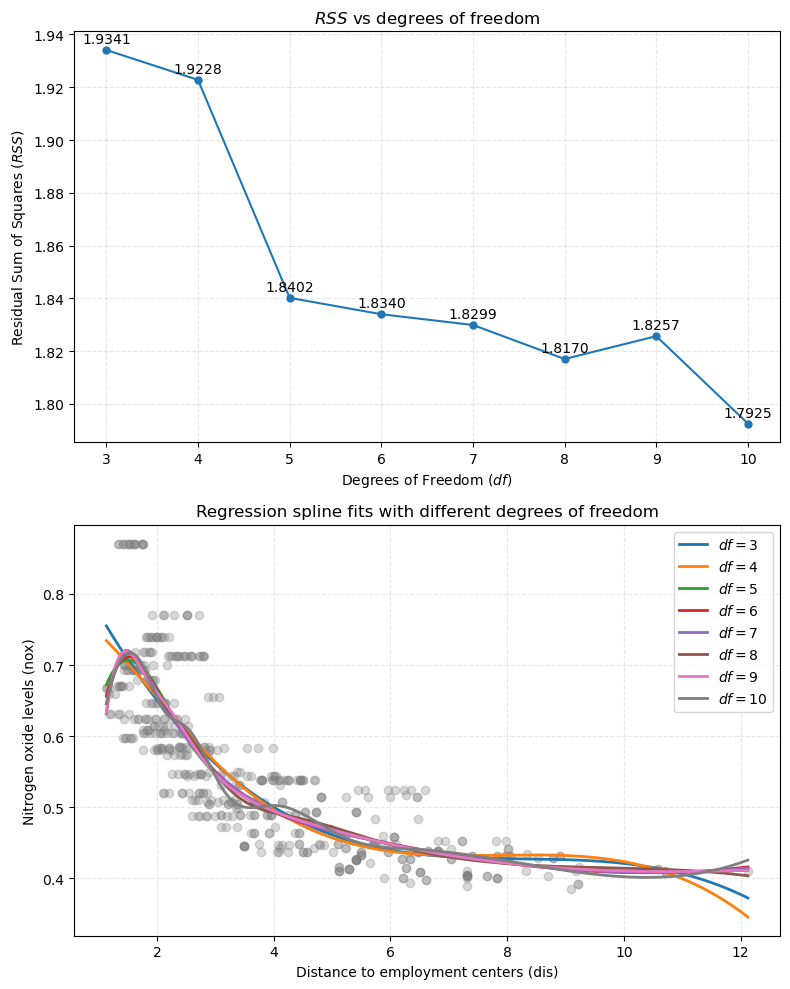

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot RSS values:
ax1.plot(list(RSS.keys()), list(RSS.values()), "o-", linewidth=1.5, ms=5)
ax1.set_xlabel("Degrees of Freedom ($ df $)")
ax1.set_ylabel("Residual Sum of Squares ($ RSS $)")
ax1.set_title("$ RSS $ vs degrees of freedom")
ax1.grid(True, alpha=0.3, linestyle="--")

# Create a table with RSS values
for i, (df, rss) in enumerate(RSS.items()):
    ax1.annotate(f"{rss:.4f}", (df, rss), textcoords="offset points", 
                 xytext=(0, 5), ha="center")

# Plot all the spline fits together:
ax2.scatter(dis, nox, facecolor="gray", alpha=0.3)
for df in df_range:
    ax2.plot(dis_grid, fits[df], linewidth=2, label=f"$ df = {df} $")
ax2.set_xlabel("Distance to employment centers (dis)")
ax2.set_ylabel("Nitrogen oxide levels (nox)")
ax2.set_title("Regression spline fits with different degrees of freedom")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()

As with polynomial regression for varying degrees, we see that there is not much of a difference
between the several splines except at the extremes of the range of the `dis` values. Moreover,
even at these extremes, the difference is more subdued than for the polynomials in item (b).

__9 (f):__  We will perform $ 5 $-fold cross-validation for all degrees
of freedom between $ 3 $ and $ 10 $, using $ R^2 $ as the score.

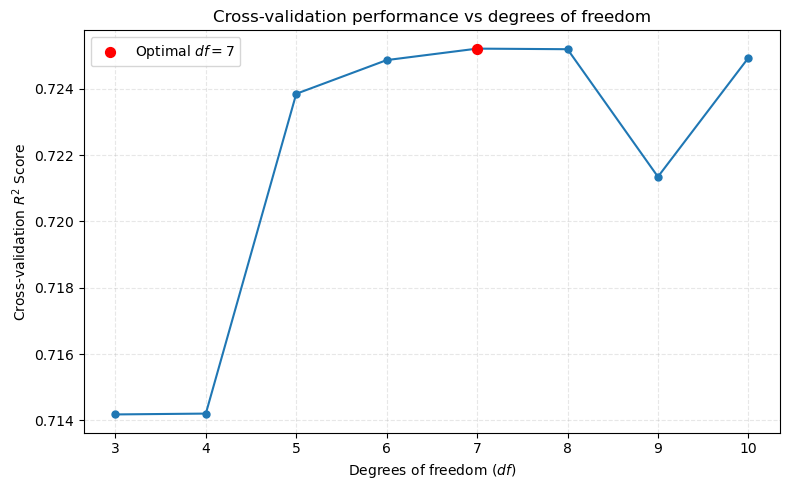

In [15]:
cv_scores = {}
df_range = range(3, 11)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
M = sklearn_sm(sm.OLS)

for d in df_range:
    # Create the basis:
    bs_model = MS([bs("dis", df=d)]).fit(boston)
    X = bs_model.transform(boston)
    # Perform cross-validation:
    cv_results = cross_validate(M, X, nox, cv=cv, scoring="r2")
    cv_scores[d] = np.mean(cv_results["test_score"])

# Plot the cross-validation results
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(cv_scores.keys()), list(cv_scores.values()),
        "o-", linewidth=1.5, ms=5)
ax.set_xlabel("Degrees of freedom ($ df $)")
ax.set_ylabel("Cross-validation $ R^2 $ Score")
ax.set_title("Cross-validation performance vs degrees of freedom")
ax.grid(True, alpha=0.3, linestyle="--")

# Mark the optimal df:
optimal_df = max(cv_scores, key=cv_scores.get)
ax.scatter([optimal_df], [cv_scores[optimal_df]], zorder=10,
           s=50, color="red", label=f"Optimal $ df = {optimal_df} $")
ax.legend()
fig.tight_layout()
plt.show()

We see that based on $ 5 $-fold cross-validated $ R^2 $, the optimal degrees of
freedom should be $ 7 $. However the difference in $ R^2 $ between all of
the splines is small.

In [16]:
# Print the scores in a table format:
cv_df = pd.DataFrame({"Degrees of freedom": list(cv_scores.keys()),
                      "CV R² Score": list(cv_scores.values())}).set_index("Degrees of freedom")
cv_df

,CV R² Score
Degrees of freedom,
3,0.714180
4,0.714205
5,0.723849
6,0.724865
7,0.725211
8,0.725193
9,0.721347
10,0.724931


Finally, let's plot the optimal cubic spline.

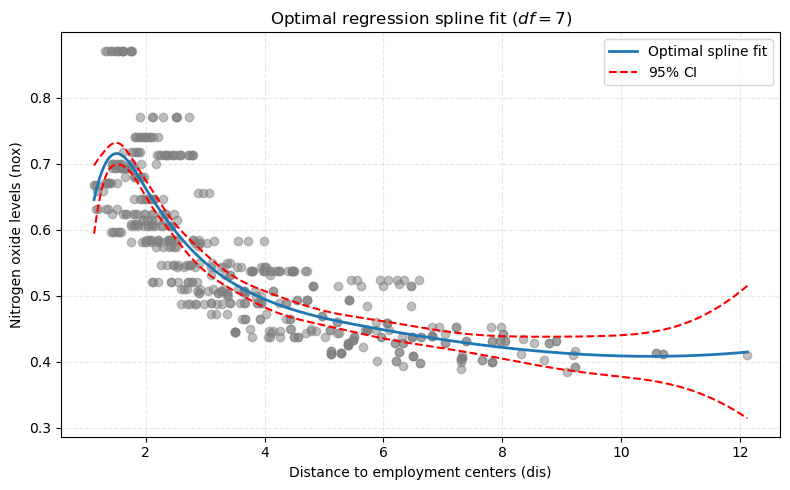

In [22]:
optimal_model = MS([bs("dis", df=optimal_df)]).fit(boston)
X = optimal_model.transform(boston)
final_model = sm.OLS(nox, X).fit()

X_grid = optimal_model.transform(dis_df)
preds = final_model.get_prediction(X_grid)
bands = preds.conf_int(alpha=0.05)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(dis, nox, facecolor="gray", alpha=0.5)
ax.plot(dis_grid, preds.predicted_mean, linewidth=2, label="Optimal spline fit")
ax.plot(dis_grid, bands[:, 0], "r--", linewidth=1.5, label="$ 95\\% $ CI")
ax.plot(dis_grid, bands[:, 1], "r--", linewidth=1.5)
ax.set_title(f"Optimal regression spline fit ($ df={optimal_df} $)")
ax.set_xlabel("Distance to employment centers (dis)")
ax.set_ylabel("Nitrogen oxide levels (nox)")
ax.legend()
ax.grid(True, alpha=0.3, linestyle="--")
fig.tight_layout()
plt.show()